# Benchmarking

In [1]:
import numpy as np 
import dask.array as da 

### Lessons learned
- [Dask local diagnostics](https://docs.dask.org/en/latest/diagnostics-local.html)
- `htop` and `multiprocessing.cpu_count()` shows you the logical, not the physical cores
    - The reason is hyperthreading: each physical CPU core can execute several threads at the same time
    - (so, if you are multiprocessing, you are also partly multithreading (?))
    - but as shown below, often it does not make much sense to use more than the number of physical cores -- hyperthreading seems to create some congestion

In [2]:
%%time 
np.arange(10**7).sum()

CPU times: user 8.08 ms, sys: 8.01 ms, total: 16.1 ms
Wall time: 15.2 ms


49999995000000

In [6]:
time = %timeit -o np.arange(10**8).sum()
print(f"Time taken: {time.average:.4f}s")

143 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time taken: 0.1434s


In [7]:
work = da.arange(10**8).sum()
time = %timeit -o work.compute()
print(f"Time taken: {time.average:.4f}s")

75 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time taken: 0.0750s


- not much of an effect for 10**7
- noticeable difference for 10**8

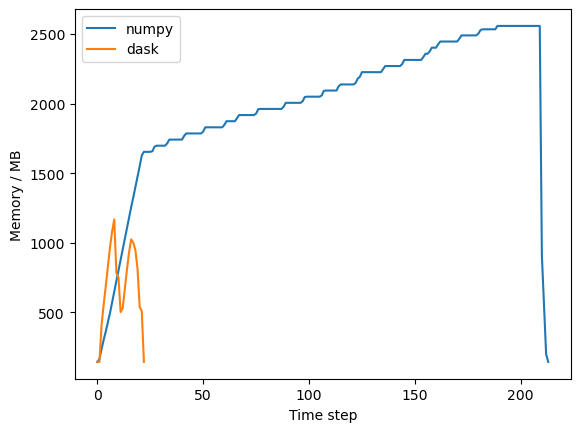

In [14]:
import numpy as np
import dask.array as da
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

exponent = 8.5

def sum_with_numpy():
    # Serial implementation
    np.arange(10**exponent).sum()

def sum_with_dask():
    # Parallel implementation
    work = da.arange(10**exponent).sum()
    work.compute()

memory_numpy = memory_usage(sum_with_numpy, interval=0.01)
memory_dask = memory_usage(sum_with_dask, interval=0.01)

# Plot results
plt.plot(memory_numpy, label='numpy')
plt.plot(memory_dask, label='dask')
plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend()
plt.show()

In [17]:
import psutil
N_physical_cores = psutil.cpu_count(logical=False)
N_logical_cores = psutil.cpu_count(logical=True)
print(f"The number of physical/logical cores is {N_physical_cores}/{N_logical_cores}")

import multiprocessing as mp 
print(f"mp shows {mp.cpu_count()} cores")

The number of physical/logical cores is 4/8
mp shows 8 cores


In [18]:
x = []
for n in range(1, 9):
    time_taken = %timeit -r 1 -o da.arange(5*10**7).sum().compute(num_workers=n)
    x.append(time_taken.average)

73.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
52.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
35.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
33.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
36.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
35.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
37.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
34.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


<Axes: xlabel='n'>

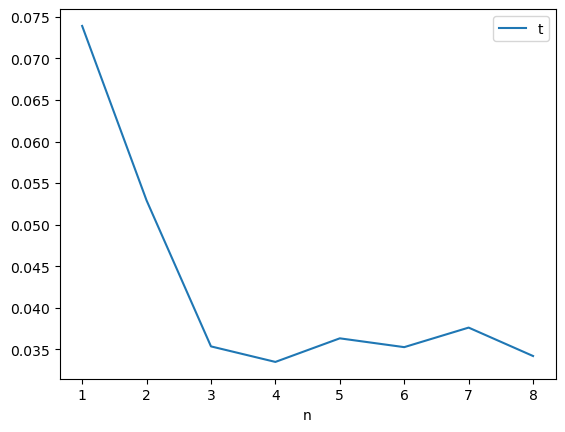

In [19]:
import pandas as pd
data = pd.DataFrame({"n": range(1, 9), "t": x})
data.set_index("n").plot()